In [44]:
!pip install pandas geopandas shapely matplotlib numpy cartopy seaborn 

In [45]:
# Cell 1: Imports and environment setup
import os
import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point, box
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Allow OGR to accept non-closed rings
os.environ["OGR_GEOMETRY_ACCEPT_UNCLOSED_RING"] = "YES"

# --- Configuration ---
base_dir = "/home/njm12/ATMS_596/Land-Water"
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_csv = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"  # Update with your CSV path
states_of_interest = ["IL", "IA", "MO"]
min_date = pd.to_datetime("1950-01-01")

In [46]:
# Cell 2: Load UMESC Mississippi River shapefiles
pool_dirs = [f"Pool {p}" for p in range(12, 27) if p != 23] + ["Open River", "Open River 2"]
gdfs = []

for pool_dir in pool_dirs:
    if "Open River" in pool_dir:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z16n83.shp"))
        local_crs = "EPSG:26916"
    else:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z15n83.shp"))
        local_crs = target_crs

    for f in shp_files:
        gdf = gpd.read_file(f)
        if gdf.crs is None:
            gdf = gdf.set_crs(local_crs)
        gdf = gdf.to_crs(target_crs)
        gdf["POOL"] = pool_dir
        gdfs.append(gdf)

umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)
print("UMESC combined:", umesc_all.shape)
print(f"Pools included: {sorted(umesc_all['POOL'].unique())}")

UMESC combined: (8050, 14)
Pools included: ['Open River', 'Open River 2', 'Pool 12', 'Pool 13', 'Pool 14', 'Pool 15', 'Pool 16', 'Pool 17', 'Pool 18', 'Pool 19', 'Pool 20', 'Pool 21', 'Pool 22', 'Pool 24', 'Pool 25', 'Pool 26']


In [47]:
# --- Derive approximate river centerline from UMESC polygons ---
# Fix invalid polygons before union
umesc_all["geometry"] = umesc_all.geometry.make_valid()
umesc_all["geometry"] = umesc_all.buffer(0)  # Ensures clean geometry

# Use the new 'union_all()' method (replaces deprecated unary_union)
river_union = umesc_all.union_all()

# Derive approximate river centerline
river_centerline = gpd.GeoSeries([river_union], crs=target_crs).buffer(-200).boundary
river_centerline = gpd.GeoDataFrame(geometry=river_centerline, crs=target_crs)
print("River centerline constructed from UMESC polygons.")

River centerline constructed from UMESC polygons.


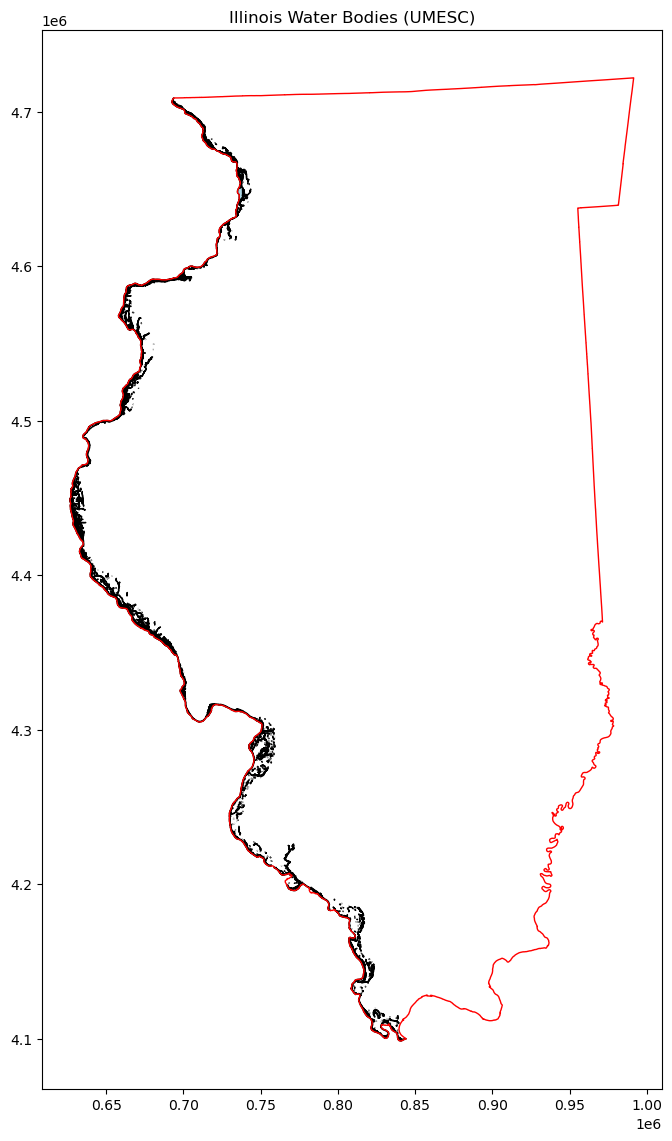

In [48]:
# Cell 3: Extract Illinois water portion
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(url)
illinois = states[states["NAME"] == "Illinois"].to_crs(target_crs)

# Filter water polygons only
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()
water_il = gpd.clip(water_only, illinois)

# Plot check
ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Illinois Water Bodies (UMESC)")
plt.show()

In [49]:
print("Number of invalid geometries in water_only:", (~water_only.is_valid).sum())
print("Invalid geometries indices:", water_only[~water_only.is_valid].index)

Number of invalid geometries in water_only: 0
Invalid geometries indices: Index([], dtype='int64')


In [50]:
# Fix invalid geometries using buffer(0) - only if needed
water_only.loc[~water_only.is_valid, "geometry"] = water_only.loc[~water_only.is_valid, "geometry"].buffer(0)

# Verify
print("Invalid geometries after fix:", (~water_only.is_valid).sum())

Invalid geometries after fix: 0


In [51]:
# Ensure Illinois geometry is valid
illinois["geometry"] = illinois["geometry"].buffer(0)

# Perform clip
water_il = gpd.clip(water_only, illinois)

print("Clipped water shapes:", water_il.shape)

Clipped water shapes: (2876, 14)


In [52]:
# Combine all Illinois water polygons into a single geometry
river_il = water_il.union_all()
print(type(river_il))
print("Bounds of Illinois river section:", river_il.bounds)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
Bounds of Illinois river section: (626594.3664122473, 4098437.22724262, 844182.0029604747, 4708927.272888837)


In [53]:
# Automatic date parsing
tornadoes = pd.read_csv(tornado_csv, parse_dates=['date'])

# Filter by states, EF-scale, and date (can include stronger tornadoes on map, if necessary / min_date will likely be changed)
tornadoes = tornadoes[
    tornadoes['st'].isin(states_of_interest) &
    tornadoes['mag'].isin([0, 1, 2, 3, 4, 5]) &
    (tornadoes['date'] >= min_date)
]

print("Filtered tornadoes:", tornadoes.shape)
print(tornadoes.head())

Filtered tornadoes: (8287, 29)
     om    yr  mo  dy       date      time  tz  st  stf  stn  ...   len  wid  \
6   198  1950  12   2 1950-12-02  15:00:00   3  IL   17    7  ...  18.8   50   
7   199  1950  12   2 1950-12-02  16:00:00   3  IL   17    8  ...  18.0  200   
9   201  1950  12   2 1950-12-02  17:30:00   3  IL   17    9  ...   9.6   50   
11    5  1950   1  25 1950-01-25  19:30:00   3  MO   29    2  ...   2.3  300   
12    6  1950   1  25 1950-01-25  21:00:00   3  IL   17    3  ...   0.1  100   

    ns  sn  sg   f1   f2  f3  f4  fc  
6    1   1   1  119  117   0   0   0  
7    1   1   1  119    5   0   0   0  
9    1   1   1  157    0   0   0   0  
11   1   1   1   93    0   0   0   0  
12   1   1   1   91    0   0   0   0  

[5 rows x 29 columns]


In [54]:
# Remove any rows with missing or invalid coordinates
coord_cols = ['slon', 'slat', 'elon', 'elat']
tornadoes = tornadoes.dropna(subset=coord_cols)

# Remove out-of-bounds or unrealistic coordinates
tornadoes = tornadoes[
    (tornadoes['slon'].between(-180, 180)) &
    (tornadoes['elon'].between(-180, 180)) &
    (tornadoes['slat'].between(-90, 90)) &
    (tornadoes['elat'].between(-90, 90))
]
print("After coordinate cleaning:", tornadoes.shape)

After coordinate cleaning: (8287, 29)


In [55]:
# --- Fix 1: Convert positive longitudes (U.S. longitudes are negative west of Greenwich) ---
tornadoes['slon'] = tornadoes['slon'].apply(lambda x: -x if x > 0 else x)
tornadoes['elon'] = tornadoes['elon'].apply(lambda x: -x if x > 0 else x)

# --- Fix 2: Remove zero or missing coordinates (invalid positions) ---
tornadoes.loc[tornadoes['slat'] == 0, 'slat'] = np.nan
tornadoes.loc[tornadoes['elat'] == 0, 'elat'] = np.nan
tornadoes.loc[tornadoes['slon'] == 0, 'slon'] = np.nan
tornadoes.loc[tornadoes['elon'] == 0, 'elon'] = np.nan

# Drop rows with NaNs after cleaning
tornadoes = tornadoes.dropna(subset=['slon', 'slat', 'elon', 'elat']).copy()

# Check coordinate ranges again
print("Longitude range (fixed):", tornadoes[['slon', 'elon']].min().min(), "to", tornadoes[['slon', 'elon']].max().max())
print("Latitude range (fixed):", tornadoes[['slat', 'elat']].min().min(), "to", tornadoes[['slat', 'elat']].max().max())

Longitude range (fixed): -96.6 to -85.23
Latitude range (fixed): 36.0022 to 45.5


In [56]:
from shapely.geometry import LineString, Point
import geopandas as gpd

# Create LineString or Point geometries
def make_geom(row):
    if pd.isna(row['elon']) or pd.isna(row['elat']) or \
       (row['elon'] == row['slon'] and row['elat'] == row['slat']):
        return Point(row['slon'], row['slat'])
    else:
        return LineString([(row['slon'], row['slat']), (row['elon'], row['elat'])])

tornadoes['geometry'] = tornadoes.apply(make_geom, axis=1)

# Convert to GeoDataFrame
tornado_gdf = gpd.GeoDataFrame(tornadoes, geometry='geometry', crs="EPSG:4326")

# Reproject to match water shapefile CRS
tornado_gdf = tornado_gdf.to_crs(target_crs)

print("Tornado geometries rebuilt")
print("Geometry types:", tornado_gdf.geometry.geom_type.value_counts())
print("Bounds:", tornado_gdf.total_bounds)

Tornado geometries rebuilt
Geometry types: LineString    4739
Point         1054
Name: count, dtype: int64
Bounds: [ 205367.62901075 3987738.95756939 1160467.39964418 5041734.47457036]


In [57]:
# Fix invalid water polygons
water_il['geometry'] = water_il['geometry'].buffer(0)

# Merge into single geometry
river_il_geom = water_il.geometry.union_all()  # or .union_all() if using new shapely

# Ensure the final geometry is valid
from shapely.validation import make_valid
river_il_geom = make_valid(river_il_geom)

In [58]:
# Buffer by 10 km
river_buffer = river_il_geom.buffer(10000)  # adjust as needed

# Check intersections with buffer
tornado_gdf['crosses_river'] = tornado_gdf.intersects(river_buffer)
crossings = tornado_gdf[tornado_gdf['crosses_river']]

print("Total weak tornadoes crossing Mississippi River or intersecting buffered zone:", crossings.shape[0])
print("Counts by EF-scale:\n", crossings['mag'].value_counts())

Total weak tornadoes crossing Mississippi River or intersecting buffered zone: 372
Counts by EF-scale:
 mag
0    124
1    122
2     79
3     37
4     10
Name: count, dtype: int64


In [59]:
## --- Step 5: Plot ---
#fig, ax = plt.subplots(figsize=(10, 14))
#water_il.plot(ax=ax, color='lightblue', edgecolor='k')
#tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
#crossings.plot(ax=ax, color='blue', linewidth=1.5, label='Crossing Tornadoes')
#gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')
#illinois.boundary.plot(ax=ax, color='black', linewidth=1)
#ax.set_title("Weak Tornadoes (EF 0–2) Crossing Mississippi River")
#ax.legend()

## Axes labels with units
#ax.set_xlabel("Easting (meters, UTM Zone 15N)")
#ax.set_ylabel("Northing (meters, UTM Zone 15N)")


## Add figure caption at the bottom
#caption = ("Figure 1. Weak tornadoes (EF 0–2) in Illinois and neighboring regions near the Mississippi River. "
#           "All tornado tracks from 2007 onward are shown in gray, while tornadoes intersecting a 10 km buffer "
#           "along the Illinois stretch of the river are highlighted in blue. Illinois water bodies are shown in light blue, "
#           "with the river buffer outlined in red. State boundaries of Illinois, Missouri, and Iowa are included for geographic context. "
#          "Coordinates are in UTM Zone 15N (meters).")
#plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

#plt.show()

#print("Tornado CRS:", tornado_gdf.crs)
#print("River CRS:", water_il.crs)
#print("River buffer bounds:", river_buffer.bounds)

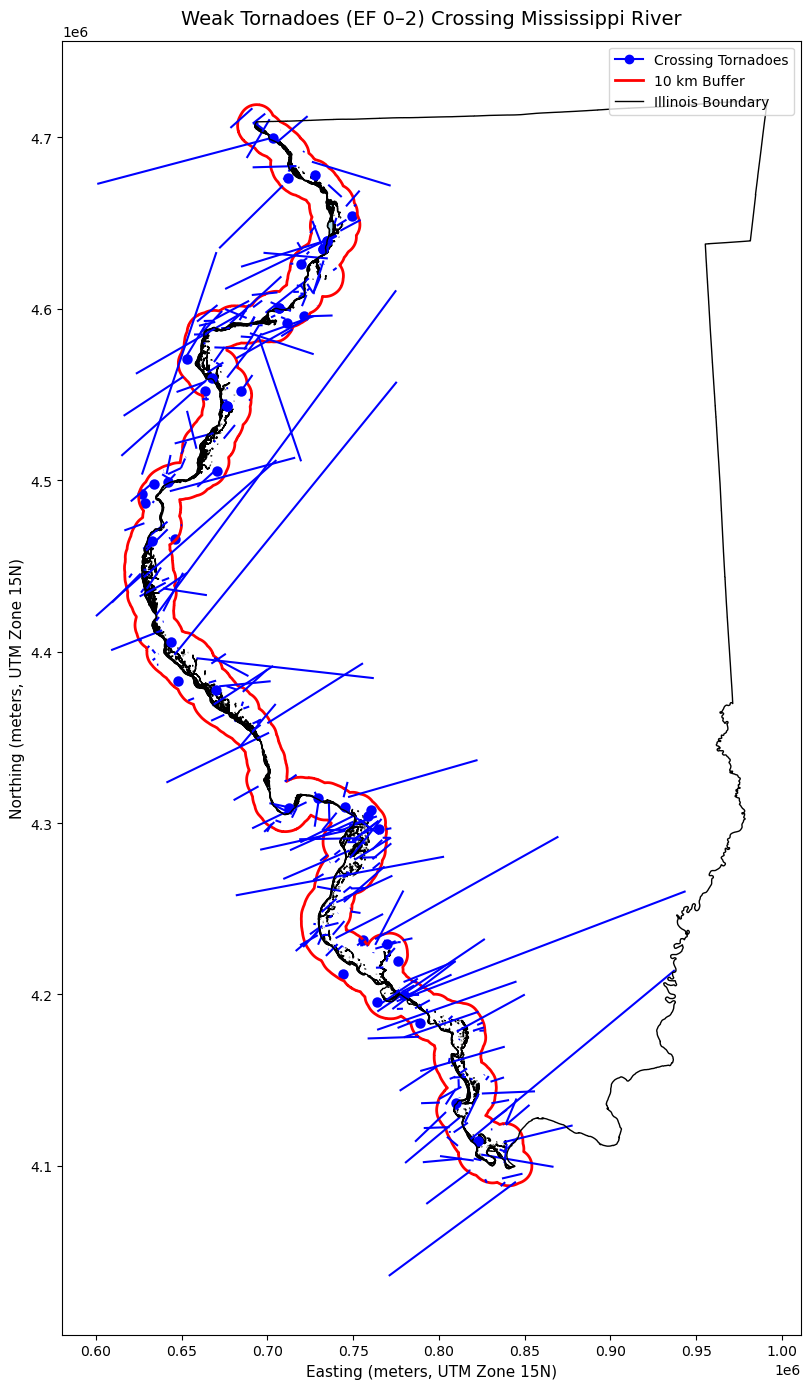

Tornado CRS: EPSG:26915
River CRS: EPSG:26915
River buffer bounds: (616595.5123264829, 4088442.1257714224, 854170.7704540391, 4718927.228456482)


In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Step: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))

# Illinois water
water_il.plot(ax=ax, color='lightblue', edgecolor='k')

# 10 km buffer boundary
gpd.GeoSeries([river_buffer]).boundary.plot(
    ax=ax, color='red', linewidth=2, label='10 km Buffer'
)

# Crossing tornadoes (lines + points)
crossings.plot(ax=ax, color='blue', linewidth=1.5)
crossings[crossings.geometry.geom_type == 'Point'].plot(
    ax=ax, color='blue', markersize=25
)

# Illinois boundary
illinois.boundary.plot(ax=ax, color='black', linewidth=1)

# --- Custom combined legend (line + point) ---
legend_elements = [
    Line2D([0], [0],
           color='blue',
           linewidth=1.5,
           marker='o',
           markersize=6,
           label='Crossing Tornadoes'),
    Line2D([0], [0],
           color='red',
           linewidth=2,
           label='10 km Buffer'),
    Line2D([0], [0],
           color='black',
           linewidth=1,
           label='Illinois Boundary'),
]

ax.legend(handles=legend_elements, loc='upper right')

ax.set_title("Weak Tornadoes (EF 0–2) Crossing Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Easting (meters, UTM Zone 15N)", fontsize=11)
ax.set_ylabel("Northing (meters, UTM Zone 15N)", fontsize=11)

plt.tight_layout()
plt.show()

print("Tornado CRS:", tornado_gdf.crs)
print("River CRS:", water_il.crs)
print("River buffer bounds:", river_buffer.bounds)

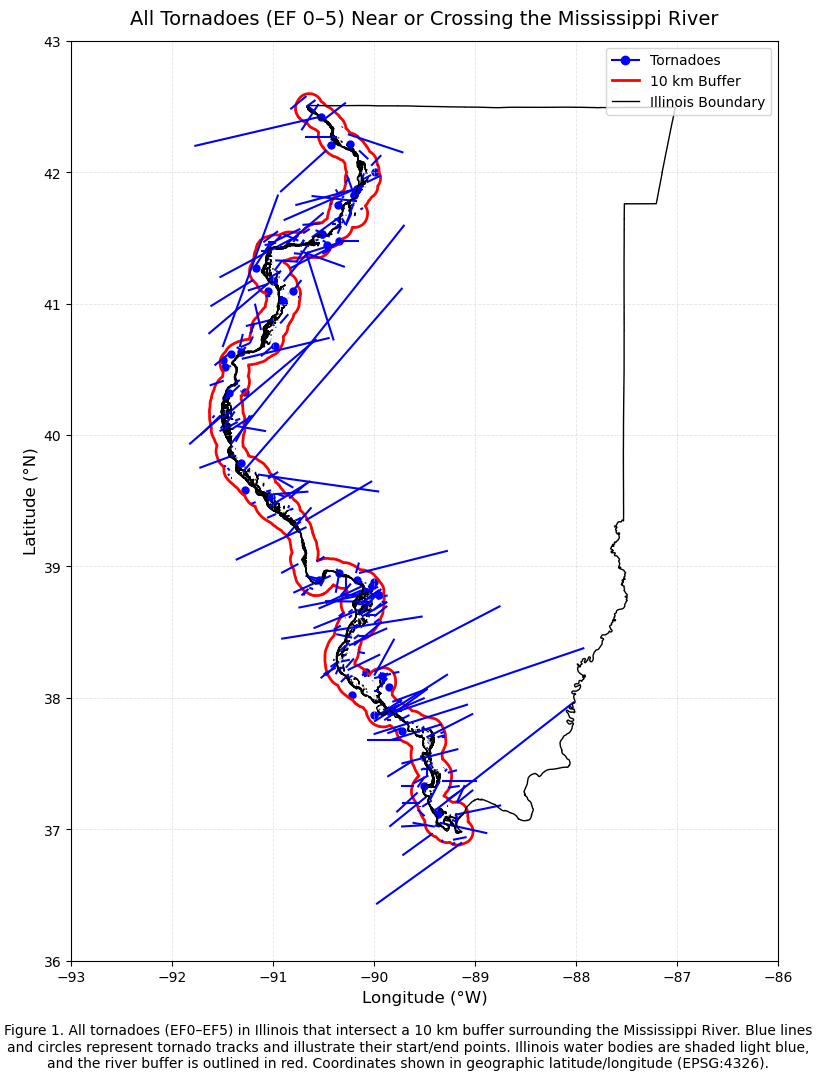

Crossing Tornado CRS: EPSG:4326
Water CRS: EPSG:4326
River buffer bounds: [-91.63046058  36.88028525 -89.02129986  42.59845461]


In [68]:
# -------------------------------------------------------
# Step 0 — Reproject everything to lat/lon (EPSG:4326)
# -------------------------------------------------------
target_crs = "EPSG:4326"

water_il_ll = water_il.to_crs(target_crs)
river_buffer_ll = gpd.GeoSeries([river_buffer], crs=water_il.crs).to_crs(target_crs)
illinois_ll = illinois.to_crs(target_crs)
crossings_ll = crossings.to_crs(target_crs)

# Keep only crossing tornadoes (lines + their points)
crossing_points_ll = crossings_ll[crossings_ll.geometry.geom_type == "Point"]
crossing_lines_ll = crossings_ll[crossings_ll.geometry.geom_type == "LineString"]

# -------------------------------------------------------
# Step 1 — Plot (Illinois + buffer + crossing tornadoes)
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 12))

# Illinois water
water_il_ll.plot(ax=ax, color='lightblue', edgecolor='k')

# 10 km river buffer
river_buffer_ll.boundary.plot(ax=ax, color='red', linewidth=2)

# Crossing tornado tracks (LINES and POINTS)
crossing_lines_ll.plot(ax=ax, color='blue', linewidth=1.5)
crossing_points_ll.plot(ax=ax, color='blue', markersize=25)

# Illinois boundary
illinois_ll.boundary.plot(ax=ax, color='black', linewidth=1)

# -----------------------------------------------------
# Add geographic grid (lat/lon ticks)
# -----------------------------------------------------
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.grid(color='lightgray', linestyle='--', linewidth=0.6, alpha=0.6)

# -------------------------------------------------------
# Step 2 — Custom combined legend
# -------------------------------------------------------
legend_elements = [
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o',
           markersize=6, label='Tornadoes'),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# -------------------------------------------------------
# Step 3 — Titles and labels
# -------------------------------------------------------
ax.set_title("All Tornadoes (EF 0–5) Near or Crossing the Mississippi River", 
             fontsize=14, pad=12)

ax.set_xlabel("Longitude (°W)", fontsize=12)
ax.set_ylabel("Latitude (°N)", fontsize=12)

# -----------------------------------------------------
# Figure caption
# -----------------------------------------------------
caption = (
    "Figure 1. All tornadoes (EF0–EF5) in Illinois that intersect a 10 km buffer surrounding the Mississippi River. "
    "Blue lines and circles represent tornado tracks and illustrate their start/end points. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. Coordinates shown in geographic latitude/longitude (EPSG:4326)."
)

plt.figtext(0.5, 0.05, caption, wrap=True, ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

# Print CRS checks
print("Crossing Tornado CRS:", crossings_ll.crs)
print("Water CRS:", water_il_ll.crs)
print("River buffer bounds:", river_buffer_ll.total_bounds)

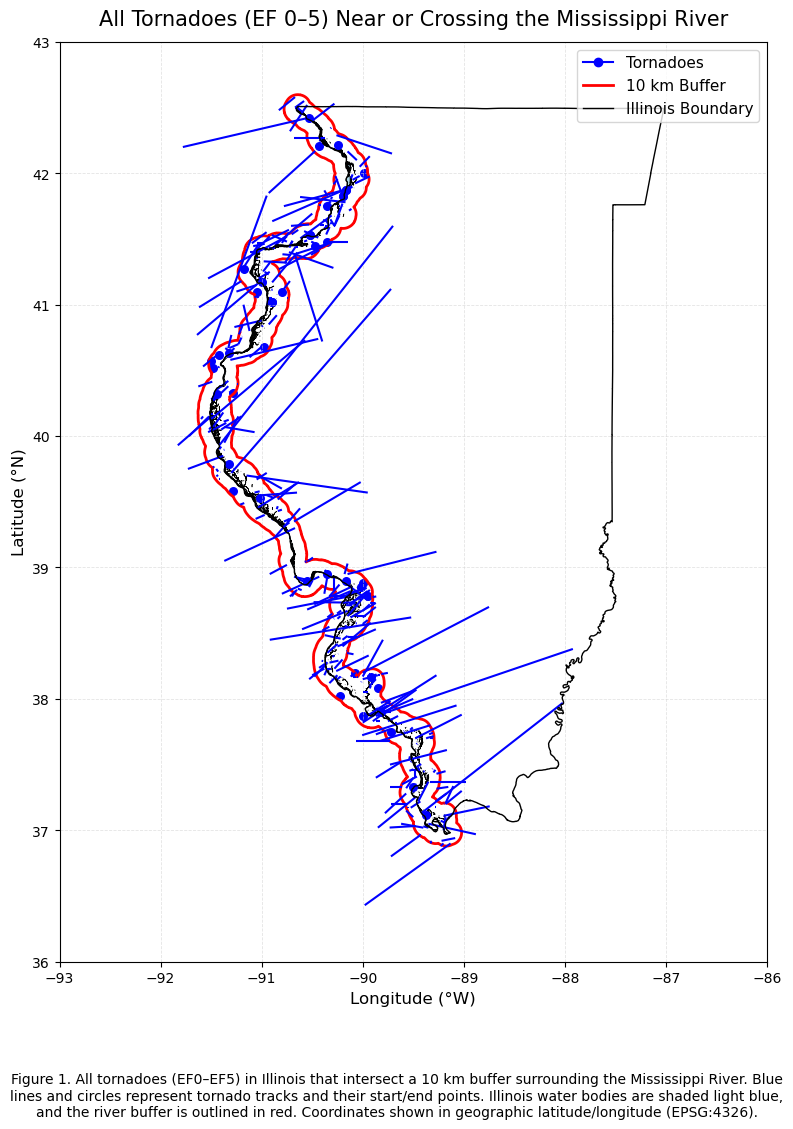

Crossing CRS: EPSG:4326
River CRS: EPSG:4326
Buffer CRS: EPSG:4326


In [62]:
# -----------------------------------------------------
# Convert everything back to geographic coordinates
# -----------------------------------------------------
target_geo = "EPSG:4326"

illinois_geo   = illinois.to_crs(target_geo)
water_il_geo   = water_il.to_crs(target_geo)
crossings_geo  = crossings.to_crs(target_geo)
river_buf_geo  = gpd.GeoSeries([river_buffer], crs=crossings.crs).to_crs(target_geo)

# -----------------------------------------------------
# Prepare crossing tornado tracks + start/end points
# -----------------------------------------------------
cross_lines  = crossings_geo[crossings_geo.geometry.geom_type == "LineString"]
cross_points = crossings_geo[crossings_geo.geometry.geom_type == "Point"]

# -----------------------------------------------------
# Create the plot
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 12))

# --- Illinois water ---
water_il_geo.plot(ax=ax, color="lightblue", edgecolor='k', linewidth=0.5)

# --- River buffer outline ---
river_buf_geo.boundary.plot(ax=ax, color="red", linewidth=2)

# --- Crossing tornado tracks (lines only) ---
cross_lines.plot(ax=ax, color="blue", linewidth=1.5)

# --- Crossing tornado start/end points ---
cross_points.plot(ax=ax, color="blue", markersize=30)

# --- Illinois boundary ---
illinois_geo.boundary.plot(ax=ax, color="black", linewidth=1)

# -----------------------------------------------------
# Add geographic grid (lat/lon ticks)
# -----------------------------------------------------
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.grid(color='lightgray', linestyle='--', linewidth=0.6, alpha=0.6)

# -----------------------------------------------------
# Custom legend (combined symbol)
# -----------------------------------------------------
legend_elements = [
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6,
           label='Tornadoes'),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

# -----------------------------------------------------
# Labels & Title
# -----------------------------------------------------
ax.set_title("All Tornadoes (EF 0–5) Near or Crossing the Mississippi River", 
             fontsize=15, pad=12)
ax.set_xlabel("Longitude (°W)", fontsize=12)
ax.set_ylabel("Latitude (°N)", fontsize=12)

# -----------------------------------------------------
# Figure caption
# -----------------------------------------------------
caption = (
    "Figure 1. All tornadoes (EF0–EF5) in Illinois that intersect a 10 km buffer surrounding the Mississippi River. "
    "Blue lines and circles represent tornado tracks and their start/end points. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. Coordinates shown in geographic latitude/longitude (EPSG:4326)."
)

plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

print("Crossing CRS:", crossings_geo.crs)
print("River CRS:", water_il_geo.crs)
print("Buffer CRS:", river_buf_geo.crs)

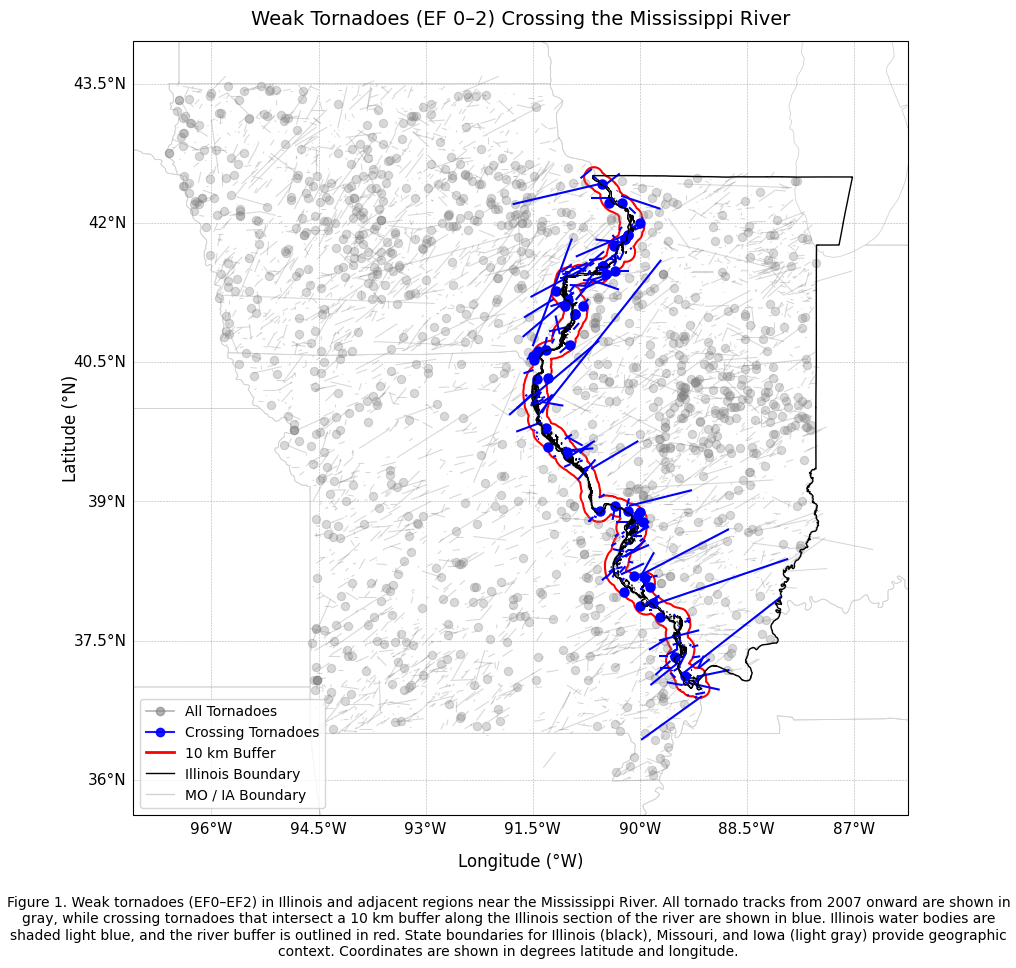

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = tornado_gdf.to_crs("EPSG:4326")
crossings_geo = crossings.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([river_buffer], crs=water_il.crs).to_crs("EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map background
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# Plot layers
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)
tornado_geo.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3, transform=ccrs.PlateCarree(), label='All Tornadoes', zorder=3)
crossings_geo.plot(ax=ax, color='blue', linewidth=1.5, transform=ccrs.PlateCarree(), label='Crossing Tornadoes', zorder=4)
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# Gridlines and coordinate labels
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# Add axis labels manually
ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# Add title and legend
ax.set_title("Weak Tornadoes (EF 0–2) Crossing the Mississippi River", fontsize=14, pad=12)
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Caption
caption = (
    "Figure 1. Weak tornadoes (EF0–EF2) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 2007 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in degrees latitude and longitude."
)
plt.figtext(0.5, 0.12, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

In [19]:
from shapely.ops import nearest_points

# --- Helper function: determine if a point is west or east of the river ---
def get_river_side(point, river_line):
    # Find nearest point ON the river line
    nearest_geom = nearest_points(point, river_line.union_all())[1]
    # Compute vector difference
    dx = point.x - nearest_geom.x
    # Simple heuristic: west (<0) vs east (>0)
    return "west" if dx < 0 else "east"

# --- Create start & end points in same CRS ---
start_points = gpd.GeoSeries(
    [Point(xy) for xy in zip(tornadoes["slon"], tornadoes["slat"])],
    crs="EPSG:4326"
).to_crs(target_crs)

end_points = gpd.GeoSeries(
    [Point(xy) for xy in zip(tornadoes["elon"], tornadoes["elat"])],
    crs="EPSG:4326"
).to_crs(target_crs)

# --- Compute river side for start and end ---
tornado_gdf["start_side"] = [get_river_side(pt, river_centerline) for pt in start_points]
tornado_gdf["end_side"]   = [get_river_side(pt, river_centerline) for pt in end_points]

# --- Compute summary statistics ---
side_summary = tornado_gdf.groupby("end_side").agg(
    count=("om", "count"),  # total tornado count
    mean_length=("len", "mean"),  # mean path length
    median_length=("len", "median"),
    tornado_days=("date", lambda x: x.dt.normalize().nunique())  # unique tornado days
).reset_index()

print("Tornado summary by ending side:")
print(side_summary)

# Optional: Compare start vs end counts
start_end_counts = pd.crosstab(
    tornado_gdf["start_side"], tornado_gdf["end_side"]
)
print("\nCross-tab of start vs end sides:")
print(start_end_counts)

Tornado summary by ending side:
  end_side  count  mean_length  median_length  tornado_days
0     east   1982     4.942003            2.1           649
1     west   3405     4.805195            2.3          1142

Cross-tab of start vs end sides:
end_side    east  west
start_side            
east        1883    42
west          99  3363


In [20]:
# --- 1. Filter to weak tornadoes intersecting the existing 10 km buffer ---
weak_near_river = tornado_gdf[
    (tornado_gdf["mag"].isin([0, 1, 2])) &
    (tornado_gdf.intersects(river_buffer))
].copy()

print(f" Weak tornadoes intersecting 10 km buffer: {len(weak_near_river)}")

# --- 2. Keep only tornadoes that do NOT cross the river (same start & end side) ---
same_side = weak_near_river[
    weak_near_river["start_side"] == weak_near_river["end_side"]
].copy()

# Drop any missing side info
same_side = same_side.dropna(subset=["start_side", "end_side"])

# --- 3. Count by side ---
same_side_counts = same_side["start_side"].value_counts().rename_axis("side").reset_index(name="count")

print("\n Tornadoes within 10 km buffer that start and end on the same side (non-crossing):")
print(same_side_counts)

# --- 4. Verify that no tornadoes cross the river ---
crossers = weak_near_river[weak_near_river["start_side"] != weak_near_river["end_side"]]
print(f" Tornadoes crossing the river: {len(crossers)}")

# --- 5. (Optional) Compute additional stats per side ---
summary = same_side.groupby("start_side").agg(
    count=("mag", "size"),
    mean_length=("len", "mean"),
    median_length=("len", "median"),
    tornado_days=("date", pd.Series.nunique)
).reset_index()

print("\n Summary stats for same-side weak tornadoes within 10 km buffer:")
print(summary)

 Weak tornadoes intersecting 10 km buffer: 325

 Tornadoes within 10 km buffer that start and end on the same side (non-crossing):
   side  count
0  east    133
1  west     90
 Tornadoes crossing the river: 102

 Summary stats for same-side weak tornadoes within 10 km buffer:
  start_side  count  mean_length  median_length  tornado_days
0       east    133     4.859098          1.300           106
1       west     90     6.755667          1.605            74


In [21]:
# --- 6. Create start and end point geometries ---
same_side["start_point"] = same_side.apply(lambda r: Point(r["slon"], r["slat"]), axis=1)
same_side["end_point"]   = same_side.apply(lambda r: Point(r["elon"], r["elat"]), axis=1)

# Convert to projected CRS
same_side = same_side.set_crs("EPSG:4326", allow_override=True).to_crs(target_crs)
same_side["start_point"] = gpd.GeoSeries(same_side["start_point"], crs="EPSG:4326").to_crs(target_crs)
same_side["end_point"]   = gpd.GeoSeries(same_side["end_point"], crs="EPSG:4326").to_crs(target_crs)

# --- 7. Apply your definitions ---

# 1️ - Tornadoes entirely inside buffer (no edge crossing)
west_inside = same_side[
    (same_side["start_side"] == "west") &
    (same_side.geometry.within(river_buffer))
].copy()

east_inside = same_side[
    (same_side["start_side"] == "east") &
    (same_side.geometry.within(river_buffer))
].copy()

# 2️ - Tornadoes outside-to-inside or inside-to-outside
west_outside = same_side[
    (same_side["start_side"] == "west") &
    (~same_side["start_point"].within(river_buffer)) &   # start outside
    (same_side["end_point"].within(river_buffer))        # end inside
].copy()

east_outside = same_side[
    (same_side["start_side"] == "east") &
    (same_side["start_point"].within(river_buffer)) &    # start inside
    (~same_side["end_point"].within(river_buffer))       # end outside
].copy()

# --- 8. Summaries ---
def side_stats(df, label):
    return {
        "label": label,
        "count": len(df),
        "mean_length": df["len"].mean(),
        "median_length": df["len"].median(),
        "mean_width": df["wid"].mean() if "wid" in df.columns else None,
    }

summary_stats = pd.DataFrame([
    side_stats(west_inside, "West - Inside (entirely within buffer)"),
    side_stats(west_outside, "West - Outside (start outside -> end inside)"),
    side_stats(east_inside, "East - Inside (entirely within buffer)"),
    side_stats(east_outside, "East - Outside (start inside -> end outside)")
])

print("\nTornado Path Statistics — ")
print(summary_stats.to_string(index=False))



Tornado Path Statistics — 
                                       label  count  mean_length  median_length  mean_width
      West - Inside (entirely within buffer)      0          NaN            NaN         NaN
West - Outside (start outside -> end inside)     14    24.680714          16.80  294.285714
      East - Inside (entirely within buffer)      0          NaN            NaN         NaN
East - Outside (start inside -> end outside)     20    18.666000          10.95  136.400000


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_126/3974715155.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_126/3974715155.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


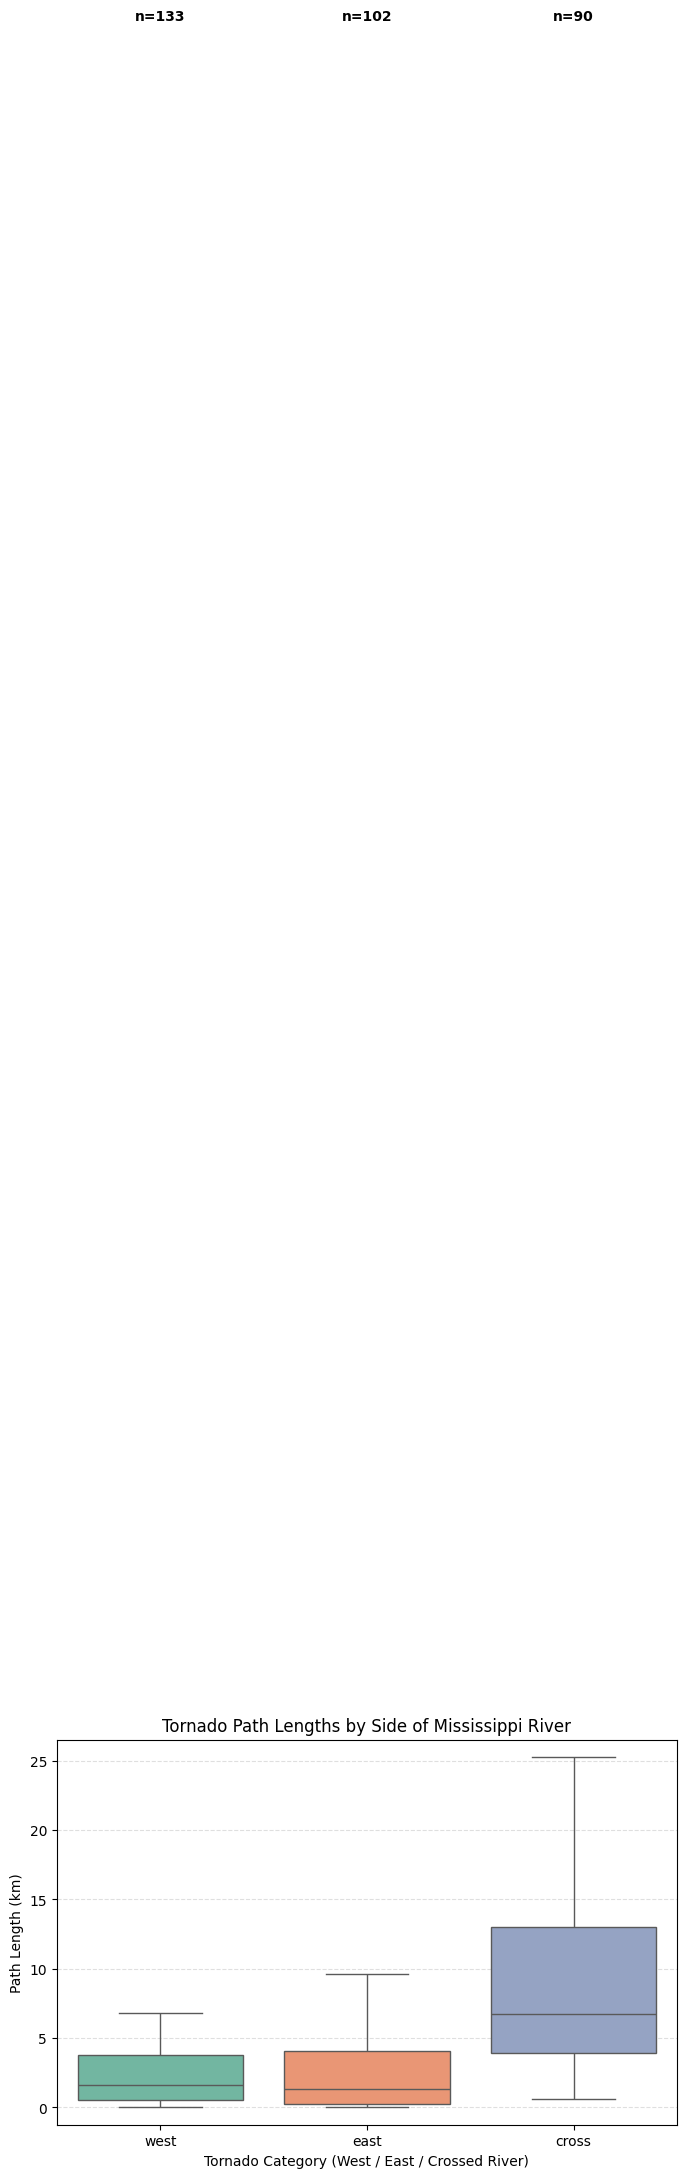

In [22]:
# --- Safe assignment using .loc ---
same_side.loc[:, "side_type"] = same_side["start_side"]
crossers.loc[:, "side_type"] = "cross"

 #Combine for plotting
plot_df = pd.concat([same_side, crossers], ignore_index=True)

# --- Boxplot ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=plot_df,
    x="side_type",
    y="len",
    hue=None,
    palette="Set2",
    showfliers=False
)

# --- Compute and annotate counts (n) for each category ---
counts = plot_df["side_type"].value_counts()

# Add the counts above each box
y_max = plot_df["len"].max()
for i, (side, n) in enumerate(counts.items()):
    plt.text(
        i, y_max * 1.02,               # position slightly above the box
        f"n={n}", 
        ha='center', va='bottom',
        fontsize=10, color='black', fontweight='bold'
    )

# --- Final formatting ---
plt.title("Tornado Path Lengths by Side of Mississippi River")
plt.xlabel("Tornado Category (West / East / Crossed River)")
plt.ylabel("Path Length (km)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

/tmp/ipykernel_126/136284146.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


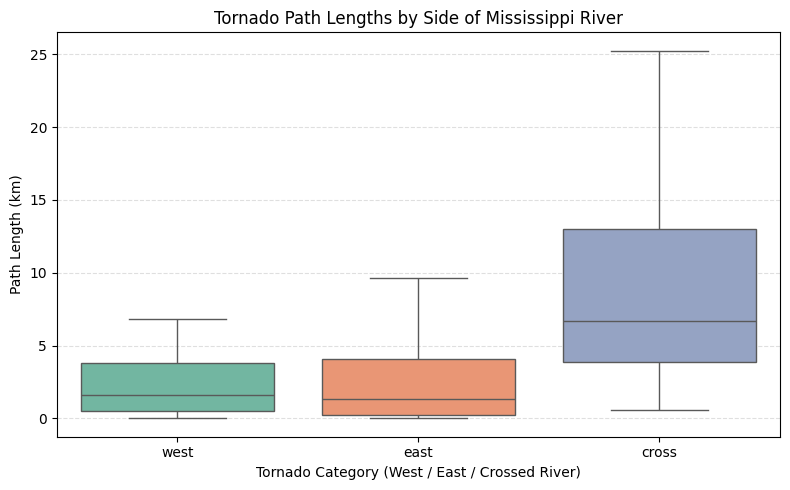

In [23]:
# --- Safe assignment using .loc ---
same_side.loc[:, "side_type"] = same_side["start_side"]
crossers.loc[:, "side_type"] = "cross"

 #Combine for plotting
plot_df = pd.concat([same_side, crossers], ignore_index=True)

# --- Boxplot ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=plot_df,
    x="side_type",
    y="len",
    hue=None,
    palette="Set2",
    showfliers=False
)
plt.title("Tornado Path Lengths by Side of Mississippi River")
plt.xlabel("Tornado Category (West / East / Crossed River)")
plt.ylabel("Path Length (km)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

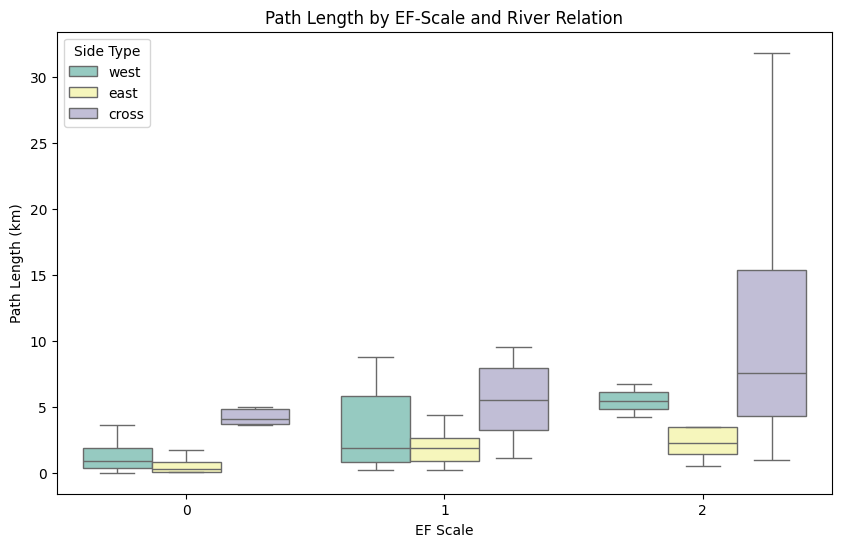

In [23]:
# --- 3. Boxplot by EF-scale ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x="mag", y="len", hue="side_type", palette="Set3", showfliers=False)
plt.title("Path Length by EF-Scale and River Relation")
plt.ylabel("Path Length (km)")
plt.xlabel("EF Scale")
plt.legend(title="Side Type")
plt.show()

In [43]:
## --- 4. Determine inside/outside of buffer for start and end points ---
#def point_in_buffer(row, buffer_geom):
#    start_pt = Point(row["slon"], row["slat"])
#    end_pt = Point(row["elon"], row["elat"])
#    return start_pt.within(buffer_geom) and end_pt.within(buffer_geom)

#tornado_gdf["entirely_within_buffer"] = tornado_gdf.apply(
#    lambda r: point_in_buffer(r, river_buffer), axis=1
#)

## --- 5. Subset non-crossing tornadoes west/east of river ---
#west_non_cross = same_side[same_side["start_side"] == "west"].copy()
#east_non_cross = same_side[same_side["start_side"] == "east"].copy()

## Add "within_buffer" classification
#west_non_cross["buffer_loc"] = west_non_cross.apply(
#    lambda r: "Within 10 km" if r["geometry"].within(river_buffer) else "Outside 10 km", axis=1
#)
#east_non_cross["buffer_loc"] = east_non_cross.apply(
#    lambda r: "Within 10 km" if r["geometry"].within(river_buffer) else "Outside 10 km", axis=1
#)

## --- 6. Plot boxplots for West non-crossing tornadoes ---
#plt.figure(figsize=(9, 6))
#sns.boxplot(data=west_non_cross, x="buffer_loc", y="len", palette="coolwarm", showfliers=False)
#sns.stripplot(data=west_non_cross, x="buffer_loc", y="len", color="k", alpha=0.5)
#plt.title("West-Side Tornado Path Lengths: Inside vs Outside 10 km Buffer")
#plt.ylabel("Path Length (km)")
#plt.xlabel("")
#plt.show()

In [44]:
## --- 7. Plot boxplots for East non-crossing tornadoes ---
#plt.figure(figsize=(9, 6))
#sns.boxplot(data=east_non_cross, x="buffer_loc", y="len", palette="viridis", showfliers=False)
#sns.stripplot(data=east_non_cross, x="buffer_loc", y="len", color="k", alpha=0.5)
#plt.title("East-Side Tornado Path Lengths: Inside vs Outside 10 km Buffer")
#plt.ylabel("Path Length (km)")
#plt.xlabel("")
#plt.show()

In [45]:
## --- 8. Summary statistics ---
#def side_stats(df, label):
#    return {
#        "label": label,
#        "count": len(df),
#        "mean_len": df["len"].mean(),
#        "median_len": df["len"].median(),
#        "mean_width": df["wid"].mean() if "wid" in df.columns else None,
#    }

#summary_stats = pd.DataFrame([
#    side_stats(west_non_cross[west_non_cross["buffer_loc"] == "Within 10 km"], "West - Within 10 km"),
#    side_stats(west_non_cross[west_non_cross["buffer_loc"] == "Outside 10 km"], "West - Outside 10 km"),
#    side_stats(east_non_cross[east_non_cross["buffer_loc"] == "Within 10 km"], "East - Within 10 km"),
#    side_stats(east_non_cross[east_non_cross["buffer_loc"] == "Outside 10 km"], "East - Outside 10 km"),
#])

#print("\nTornado Path Length Summary (Inside vs Outside 10 km buffer, Non-crossing only):")
#print(summary_stats.to_string(index=False))

Total weak tornadoes in bounding box: 0
Counts by EF-scale:
 Series([], Name: count, dtype: int64)


/tmp/ipykernel_141/2338234353.py:49: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  tornado_in_box.plot(ax=ax, color='orange', linewidth=1, label='Tornado Tracks')


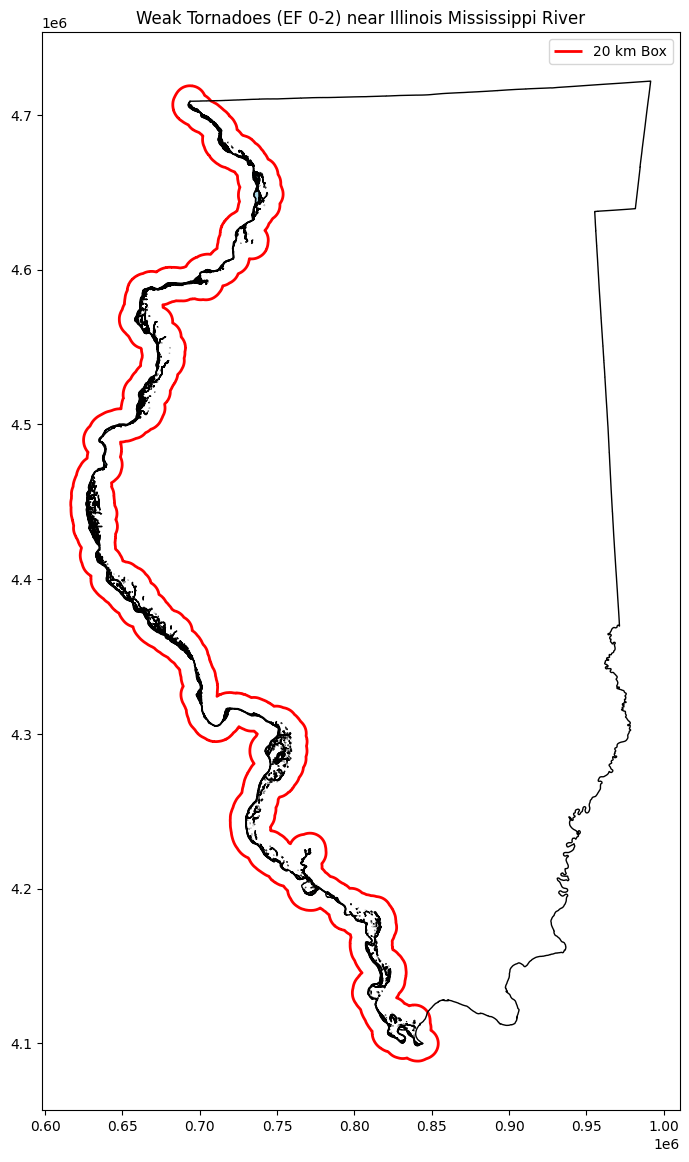

In [25]:
#Extra work: 

import geopandas as gpd
from shapely.geometry import LineString, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# --- Step 1: Ensure tornado geometries are valid ---
tornado_gdf['geometry'] = tornado_gdf['geometry'].buffer(0)

# --- Step 2: Create Mississippi River centerline along Illinois ---
# Merge water polygons and get river centerline
river_il_geom = water_il.geometry.buffer(0).union_all()

# Simplify river to line for bounding box (optional)
# If MultiPolygon, take exterior boundaries and create line
from shapely.ops import linemerge
river_lines = []
if river_il_geom.geom_type == 'MultiPolygon':
    for poly in river_il_geom.geoms:
        river_lines.append(poly.exterior)
    river_centerline = linemerge(river_lines)
else:
    river_centerline = river_il_geom.exterior

# --- Step 3: Create 20 km wide bounding box along river ---
# 10 km on either side (buffer)
buffer_distance = 10000  # meters
river_bbox = river_centerline.buffer(buffer_distance)

# Only set CRS if missing, otherwise just transform
if tornado_gdf.crs is None:
    tornado_gdf = tornado_gdf.set_crs("EPSG:4326")
tornado_gdf = tornado_gdf.to_crs(target_crs)

# --- Step 4: Filter tornadoes intersecting bounding box ---
tornado_in_box = tornado_gdf[tornado_gdf.intersects(river_bbox)]

# --- Step 5: Summed counts by EF-scale ---
ef_counts = tornado_in_box['mag'].value_counts().sort_index()
print("Total weak tornadoes in bounding box:", tornado_in_box.shape[0])
print("Counts by EF-scale:\n", ef_counts)

# --- Step 6: Plot tornado tracks and bounding box ---
fig, ax = plt.subplots(figsize=(10, 14))
# Plot Illinois water as light blue
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
# Plot tornado tracks in bounding box
tornado_in_box.plot(ax=ax, color='orange', linewidth=1, label='Tornado Tracks')
# Plot bounding box outline in red
gpd.GeoSeries([river_bbox]).boundary.plot(ax=ax, color='red', linewidth=2, label='20 km Box')
# Plot Illinois boundary
illinois.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Weak Tornadoes (EF 0-2) near Illinois Mississippi River")
ax.legend()
plt.show()

In [26]:
print("Tornado CRS:", tornado_gdf.crs)
print("River CRS:", water_il.crs)

print("\nTornado bounds (projected):", tornado_gdf.total_bounds)
print("River bounds (projected):", water_il.total_bounds)
print("River bbox bounds:", river_bbox.bounds)

Tornado CRS: EPSG:26915
River CRS: EPSG:26915

Tornado bounds (projected): [nan nan nan nan]
River bounds (projected): [ 626594.36641225 4098437.22724262  844182.00296047 4708927.27288884]
River bbox bounds: (616595.5123264829, 4088442.1257714224, 854170.7704540391, 4718927.228456482)


In [ ]:
print(tornado_gdf.geometry.head())
print("Number of valid geometries:", tornado_gdf.geometry.notnull().sum())
print("Total tornadoes:", len(tornado_gdf))
print("Empty geometries:", tornado_gdf.geometry.is_empty.sum())

/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:962: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


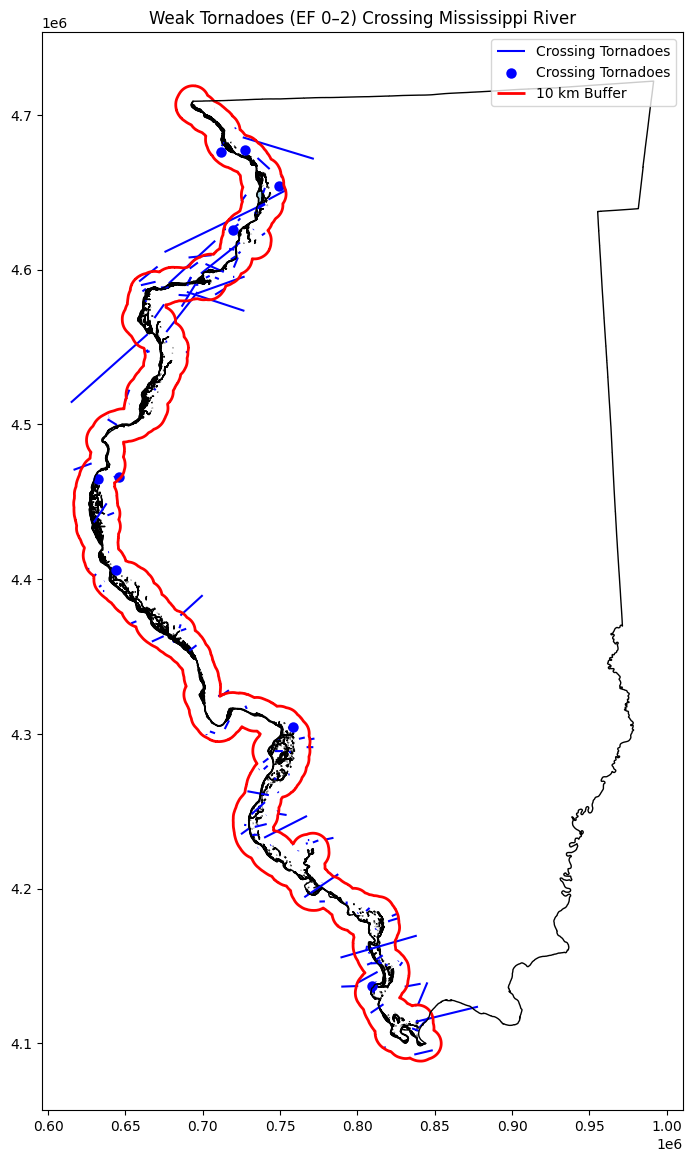

Tornado CRS: EPSG:26915
River CRS: EPSG:26915
River buffer bounds: (616595.5123264829, 4088442.1257714224, 854170.7704540391, 4718927.228456482)


In [18]:
# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
crossings.plot(ax=ax, color='blue', linewidth=1.5, label='Crossing Tornadoes')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')
illinois.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Weak Tornadoes (EF 0–2) Crossing Mississippi River")
ax.legend()
plt.show()

print("Tornado CRS:", tornado_gdf.crs)
print("River CRS:", water_il.crs)
print("River buffer bounds:", river_buffer.bounds)